In [8]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2

In [9]:
import os
os.chdir('..')
!pwd

# append sys.path
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
sys.path.append('./src')

from simulator.DM_model import DM_model
from parse_data.decode_parameter import decode_mat_fitted_parameters
from parse_data.parse_trial_data import parse_trial_data, compute_subject_acc, correctness_of_array
import os
import numpy as np

/home/wehe/tmp/NSC/codes


In [10]:
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True

# remove all edges
# mpl.rcParams["axes.edgecolor"] = "none"

font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

mpl.rc('font', **font)


## generate input seqC

In [11]:
from dataset.seqC_generator import seqC_generator
seqC = seqC_generator().generate(
    MS_list=[0.2, 0.4, 0.8], 
    dur_list=[3,5,7,9,11,13,15],
    seqC_sample_per_MS=700*100,
)
seqC.shape

---
generated seqC info
dur_list: [3, 5, 7, 9, 11, 13, 15]
MS_list: [0.2, 0.4, 0.8]
seqC_sample_per_MS: 70000
generated seqC shape: (7, 3, 70000, 15)


(7, 3, 70000, 15)

## sampling from the prior BoxUniform

In [12]:
from sbi import utils as utils
import torch

# model B-G-L0S-O-N-
prior_min = [-3.7, -36, 0, -34, 5]
prior_max = [2.5, 71, 0, 18, 7]
num_sample = int(10**(len(prior_min)-1))
prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

theta = prior.sample((num_sample,))
theta.shape

torch.Size([10000, 5])

Text(0, 0.5, 'count')

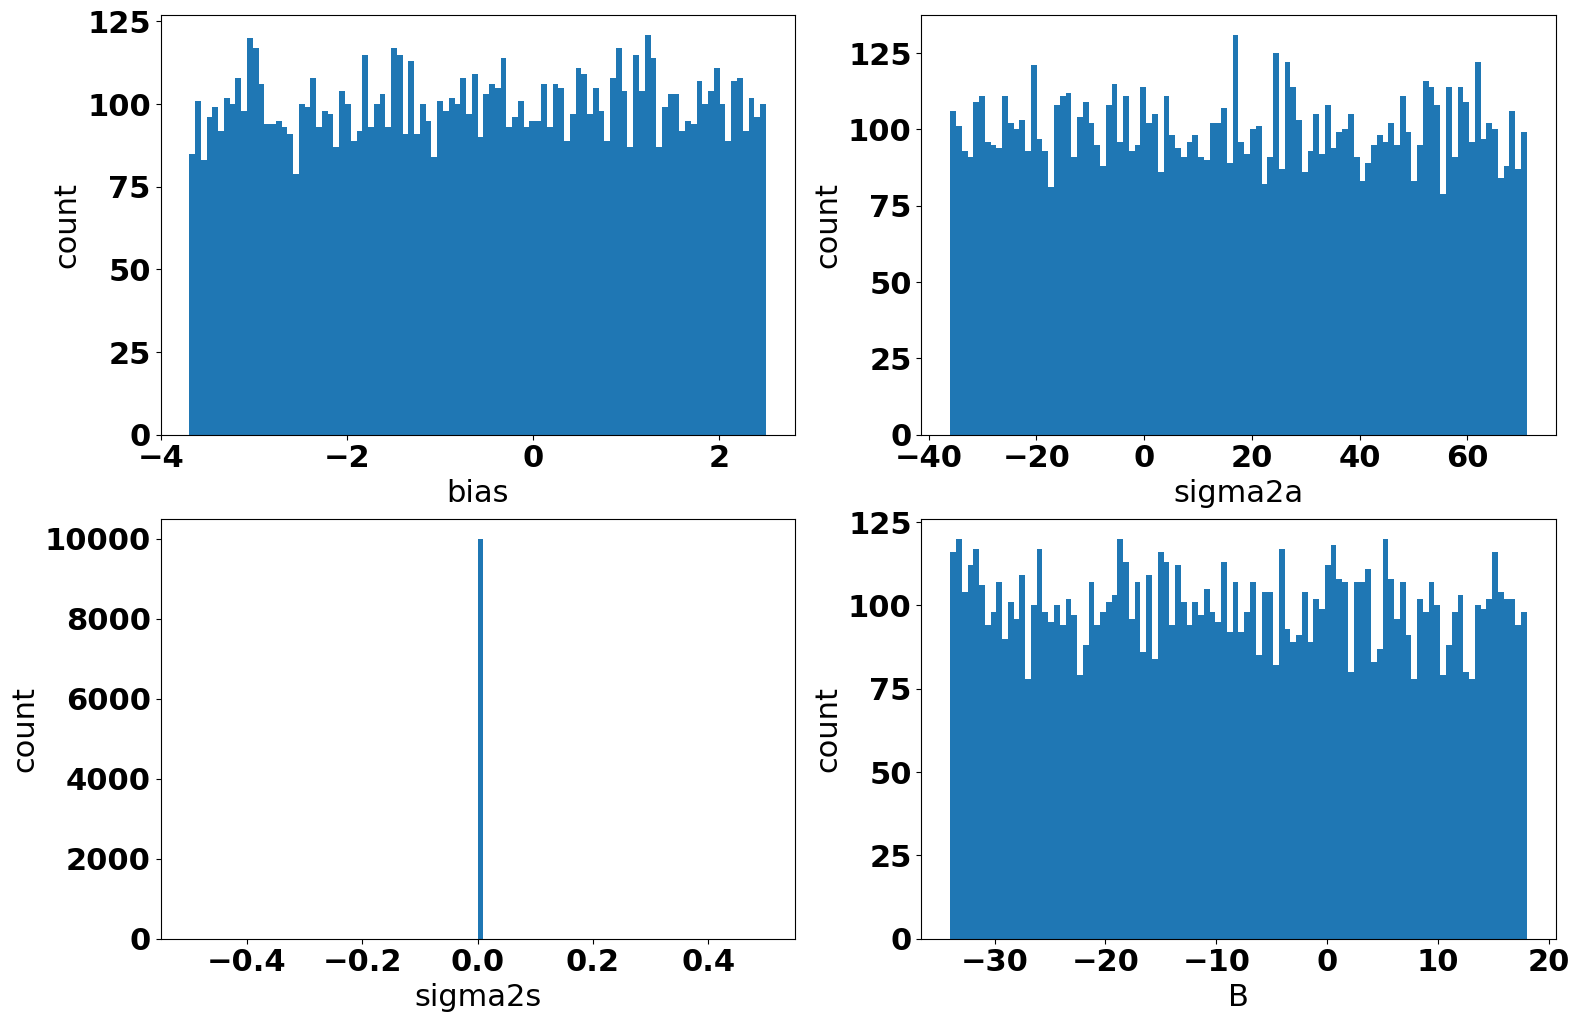

In [13]:
fig = plt.figure(figsize=(18, 12))
gs = mpl.gridspec.GridSpec(2, 2)

ax = fig.add_subplot(gs[0, 0])
ax.hist(theta[:,0], bins=100)
ax.set_xlabel('bias')
ax.set_ylabel('count')

ax = fig.add_subplot(gs[0, 1])
ax.hist(theta[:,1], bins=100)
ax.set_xlabel('sigma2a')
ax.set_ylabel('count')

ax = fig.add_subplot(gs[1, 0])
ax.hist(theta[:,2], bins=100)
ax.set_xlabel('sigma2s')
ax.set_ylabel('count')

ax = fig.add_subplot(gs[1, 1])
ax.hist(theta[:,3], bins=100)
ax.set_xlabel('B')
ax.set_ylabel('count')

## pipeline for generating the dataset and collate_fn

In [98]:
from dataset.seqC_generator import seqC_generator
seqC = seqC_generator().generate(
    dur_list = [3,7,11,15],
    MS_list  = [0.4, 0.8], 
    seqC_sample_per_MS=5,
)
seqC.shape

---
generated seqC info
dur_list: [3, 7, 11, 15]
MS_list: [0.4, 0.8]
seqC_sample_per_MS: 5
generated seqC shape: (4, 2, 5, 15)


(4, 2, 5, 15)

In [99]:
from dataset.dataset_pipeline import training_dataset
from dataset.model_sim_pR import DM_sim_for_seqCs_parallel, get_boxUni_prior
from config.load_config import load_config

In [100]:
config = load_config()
config['dataset']['Rchoice_method'] = 'probR_sampling'

proposal = get_boxUni_prior(
    prior_min=config['prior']['prior_min'],
    prior_max=config['prior']['prior_max'],
)
seqC = seqC_generator(nan_padding=None).generate(
    dur_list            = config['x_o']['chosen_dur_list'],
    MS_list             = config['x_o']['chosen_MS_list'],
    seqC_sample_per_MS  = config['x_o']['seqC_sample_per_MS'],
)

seqC, theta, probR = DM_sim_for_seqCs_parallel(
        seqCs           = seqC,
        prior           = proposal,
        num_prior_sample= config['prior']['num_prior_sample'],
        model_name      = config['simulator']['model_name'],
)

dataset = training_dataset(config)
x, theta = dataset.data_process_pipeline(
    seqC, theta, probR
)

---
generated seqC info
dur_list: [3, 7, 11, 15]
MS_list: [0.4, 0.8]
seqC_sample_per_MS: 5
generated seqC shape: (4, 2, 5, 15)
---
simulating pR with... 
prior sample size: 500
model_name: B-G-L0S-O-N-
total number of simulations 20000 with 16 workers
---


./src/config/load_config.py:64: UserWarning: config_simulator_path is not specified, use default: src/config/test/test_simulator.yaml
  warnings.warn(f'config_simulator_path is not specified, use default: {config_simulator_path}')
./src/config/load_config.py:70: UserWarning: config_train_path is not specified, use default: src/config/test/test_train.yaml
  warnings.warn(f'config_train_path is not specified, use default: {config_train_path}')
./src/config/load_config.py:84: UserWarning: config_dataset_path is not specified, use default: src/config/test/test_dataset.yaml
  warnings.warn(f'config_dataset_path is not specified, use default: {config_dataset_path}')
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    2.1s
[Parallel(n_jobs=16)]: Done 640 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 15616 tasks      | elapsed:    4.2s
[Parallel(n_jobs=16)]: Done 19969 out of 20000 | elapsed:    4.8s 

time elapsed for simulation: 4.83 seconds
stacking the results
done stacking the results
---
Computed seqCs.shape: (4, 2, 5, 15), theta.shape: (4, 2, 5, 500, 4), probR.shape: (4, 2, 5, 500, 1)
---
start processing for x, theta 
with inputs: seqC.shape (4, 2, 5, 500, 15), theta.shape (4, 2, 5, 500, 4), probR.shape (4, 2, 5, 500, 1)

before reshape_shuffle_x_theta: 
x.shape=(4, 2, 5, 500, 100, 16), theta.shape=(4, 2, 5, 500, 100, 4)

reshaped and shuffled: 
x.shape torch.Size([50000, 40, 16]) theta.shape torch.Size([50000, 4])
you chose not to save the training data


In [101]:
theta

tensor([[ -1.8720,  15.0803,   0.5617,  -3.9658],
        [ -1.8720,  15.0803,   0.5617,  -3.9658],
        [ -1.8720,  15.0803,   0.5617,  -3.9658],
        ...,
        [  1.5396,   7.7919,   9.1725, -10.0936],
        [  1.5396,   7.7919,   9.1725, -10.0936],
        [  1.5396,   7.7919,   9.1725, -10.0936]], dtype=torch.float64)

In [102]:
config = load_config()
config['dataset']['Rchoice_method'] = 'probR'

proposal = get_boxUni_prior(
    prior_min=config['prior']['prior_min'],
    prior_max=config['prior']['prior_max'],
)
seqC = seqC_generator(nan_padding=None).generate(
    dur_list            = config['x_o']['chosen_dur_list'],
    MS_list             = config['x_o']['chosen_MS_list'],
    seqC_sample_per_MS  = config['x_o']['seqC_sample_per_MS'],
)

seqC, theta, probR = DM_sim_for_seqCs_parallel(
        seqCs           = seqC,
        prior           = proposal,
        num_prior_sample= config['prior']['num_prior_sample'],
        model_name      = config['simulator']['model_name'],
)

dataset = training_dataset(config)
x, theta = dataset.data_process_pipeline(
    seqC, theta, probR
)

---
generated seqC info
dur_list: [3, 7, 11, 15]
MS_list: [0.4, 0.8]
seqC_sample_per_MS: 5
generated seqC shape: (4, 2, 5, 15)
---
simulating pR with... 
prior sample size: 500
model_name: B-G-L0S-O-N-
total number of simulations 20000 with 16 workers
---


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1248 tasks      | elapsed:    0.4s


time elapsed for simulation: 2.52 seconds
stacking the results
done stacking the results
---
Computed seqCs.shape: (4, 2, 5, 15), theta.shape: (4, 2, 5, 500, 4), probR.shape: (4, 2, 5, 500, 1)
---
start processing for x, theta 
with inputs: seqC.shape (4, 2, 5, 500, 15), theta.shape (4, 2, 5, 500, 4), probR.shape (4, 2, 5, 500, 1)

before reshape_shuffle_x_theta: 
x.shape=(4, 2, 5, 500, 1, 16), theta.shape=(4, 2, 5, 500, 1, 4)

reshaped and shuffled: 
x.shape torch.Size([500, 40, 16]) theta.shape torch.Size([500, 4])
you chose not to save the training data


[Parallel(n_jobs=16)]: Done 19220 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 20000 out of 20000 | elapsed:    2.5s finished


In [103]:
x[0, :][:2, :], theta[0, :]

(tensor([[0.5000, 0.9000, 0.1000, 0.1000, 0.9000, 0.5000, 0.1000, 0.9000, 0.9000,
          0.9000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5452],
         [0.5000, 0.1000, 0.9000, 0.9000, 0.5000, 0.5000, 0.1000, 0.1000, 0.9000,
          0.5000, 0.5000, 0.1000, 0.9000, 0.9000, 0.1000, 0.5342]],
        dtype=torch.float64),
 tensor([-7.5702e-01,  4.0458e+01,  7.0441e+00, -9.3517e-03],
        dtype=torch.float64))

test torch.repeat_interleave and torch.bernoulli functions

In [104]:
x_ = torch.tensor([[1,2,3],[4,5,6]])
print(x_.shape, x_)
x_ = x_.repeat_interleave(10, dim=0)
print(x_.shape, x_)

torch.Size([2, 3]) tensor([[1, 2, 3],
        [4, 5, 6]])
torch.Size([20, 3]) tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [4, 5, 6],
        [4, 5, 6],
        [4, 5, 6],
        [4, 5, 6],
        [4, 5, 6],
        [4, 5, 6],
        [4, 5, 6],
        [4, 5, 6],
        [4, 5, 6],
        [4, 5, 6]])


In [105]:
a = torch.tensor([[0.2,0.1,0.5],[0.3,0.5,0.7]]).unsqueeze_(dim=-1)
print(a.shape)
a = a.repeat_interleave(100, dim=0)
print(a.shape)
a = torch.bernoulli(a)
print(a.shape)

torch.Size([2, 3, 1])
torch.Size([200, 3, 1])
torch.Size([200, 3, 1])


In [106]:
torch.sum(a[:100, :, :]/100, dim=0), torch.sum(a[100:200, :, :]/100, dim=0)

(tensor([[0.1800],
         [0.1100],
         [0.4000]]),
 tensor([[0.3000],
         [0.5100],
         [0.6500]]))

In [122]:
def my_collate_fn(batch, Rchoice_method='probR_sampling', num_probR_sample=10):
    # theta, x, _ = zip(*batch)
    theta, x    = zip(*batch)
    
    theta   = torch.stack(theta)
    x       = torch.stack(x)
    
    if Rchoice_method == 'probR':
        # repeat theta and x for each probR sample
        theta_new   = theta.repeat_interleave(num_probR_sample, dim=0)
        x_new       = x.repeat_interleave(num_probR_sample, dim=0)
        x_seqC      = x_new[:, :, :-1]
        x_probRs    = x_new[:, :, -1].unsqueeze_(dim=2)
        
        # sample Rchoice from probR with Bernoulli
        x_Rchoice   = torch.bernoulli(x_probRs)
        x           = torch.cat((x_seqC, x_Rchoice), dim=2)
        theta       = theta_new
    
    return theta, x

In [123]:
batch_size = 2

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

data = TensorDataset(theta, x)
for i in range(1):
    sample = data[i]
    print('some examples of the dataset:', i,
            f'\ntheta[{i}]:\n', sample[0], 
            f'\nx[{i}]:\n', sample[1]
            )

# Get total number of training examples.
num_examples = theta.size(0)
# Select random train and validation splits from (theta, x) pairs.
num_training_examples = int((1 - 0.2) * num_examples)
num_validation_examples = num_examples - num_training_examples


# Seperate indicies for training and validation
permuted_indices = torch.randperm(num_examples)
train_indices, val_indices = (
    permuted_indices[:num_training_examples],
    permuted_indices[num_training_examples:],
)

train_loader_kwargs = {
    "batch_size": min(batch_size, num_training_examples),
    "drop_last": True,
    "sampler": SubsetRandomSampler(train_indices.tolist()),
}
val_loader_kwargs = {
    "batch_size": min(batch_size, num_validation_examples),
    "shuffle": False,
    "drop_last": True,
    "sampler": SubsetRandomSampler(val_indices.tolist()),
}

dataloader_kwargs = {
    "collate_fn": lambda batch: my_collate_fn(batch, Rchoice_method=config['dataset']['Rchoice_method'], num_probR_sample=config['dataset']['num_probR_sample']),
                     }
if dataloader_kwargs is not None:
    train_loader_kwargs = dict(train_loader_kwargs, **dataloader_kwargs)
    val_loader_kwargs = dict(val_loader_kwargs, **dataloader_kwargs)

train_loader = DataLoader(data, **train_loader_kwargs)
val_loader = DataLoader(data, **val_loader_kwargs)

some examples of the dataset: 0 
theta[0]:
 tensor([-7.5702e-01,  4.0458e+01,  7.0441e+00, -9.3517e-03],
       dtype=torch.float64) 
x[0]:
 tensor([[0.5000, 0.9000, 0.1000, 0.1000, 0.9000, 0.5000, 0.1000, 0.9000, 0.9000,
         0.9000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5452],
        [0.5000, 0.1000, 0.9000, 0.9000, 0.5000, 0.5000, 0.1000, 0.1000, 0.9000,
         0.5000, 0.5000, 0.1000, 0.9000, 0.9000, 0.1000, 0.5342],
        [0.5000, 0.1000, 0.5000, 0.9000, 0.9000, 0.5000, 0.5000, 0.5000, 0.9000,
         0.1000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5398],
        [0.5000, 0.5000, 0.9000, 0.1000, 0.1000, 0.5000, 0.1000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5362],
        [0.5000, 0.3000, 0.3000, 0.5000, 0.3000, 0.3000, 0.7000, 0.7000, 0.5000,
         0.5000, 0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5318],
        [0.5000, 0.3000, 0.5000, 0.5000, 0.7000, 0.7000, 0.7000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.

check the output of the dataloader

In [124]:
a = next(iter(train_loader))

probR 100
torch.Size([2, 4]) torch.Size([2, 40, 16])
torch.Size([200, 40, 15]) torch.Size([200, 40, 1]) torch.Size([200, 40, 16])
tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.3000, 0.5000, 0.5000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.9000, 0.5000, 0.9000, 0.1000, 0.9000, 0.9000, 0.9000, 0.1000,
         0.1000, 0.5000, 0.5000, 0.9000, 0.9000, 0.1000],
        [0.5000, 0.9000, 0.1000, 0.9000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.5000, 0.1000, 0.1000, 0.9000, 0.5000, 0.1000],
        [0.5000, 0.7000, 0.5000, 0.3000, 0.3000, 0.5000, 0.7000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.9000, 0.1000, 0.1000, 0.1000, 0.9000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.7000, 0.5000, 0.3000, 0.5000, 0.7000, 0.3000, 0.7000,
         0.7000, 0.5000, 0.3000, 0.7000, 0.3000, 0.7000],
        [0.5000, 0.9000, 0.9000, 0.0

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        x = torch.tensor(sample["input"], dtype=torch.float32)
        y = torch.tensor(sample["output"], dtype=torch.float32)
        return x, y

def custom_collate_fn(batch):
    print(batch[0])
    inputs, targets = zip(*batch)
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)
    return inputs, targets
    # return batch

data = [
    {"input": [1, 2, 3], "output": [2, 4, 6]},
    {"input": [4, 5, 6], "output": [8, 10, 12]},
    {"input": [7, 8, 9], "output": [14, 16, 18]},
    {"input": [10, 11, 12], "output": [20, 22, 24]}
]

dataset = CustomDataset(data)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=custom_collate_fn)
# dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

for batch_idx, batch in enumerate(dataloader):
    inputs, targets = batch
    print(f"Batch {batch_idx}: inputs shape = {inputs.shape}, targets shape = {targets.shape}")
    # print(inputs)


(tensor([7., 8., 9.]), tensor([14., 16., 18.]))
Batch 0: inputs shape = torch.Size([2, 3]), targets shape = torch.Size([2, 3])
(tensor([10., 11., 12.]), tensor([20., 22., 24.]))
Batch 1: inputs shape = torch.Size([2, 3]), targets shape = torch.Size([2, 3])


In [132]:
targets

tensor([[ 2.,  4.,  6.],
        [20., 22., 24.]])